In [4]:
# Usual suspect
import sys
sys.path.insert(1, '../') 

%reload_ext autoreload
%autoreload 2

# <center> **Cultural heritage study: Marble statue**<center>

This jupyter notebook provides a **tutorial** on muon **scattering tomography** in the context of **cultural heritage**. 

Based on **simulated data**, this work presents how standard reconstruction algorithms perform in the regime of 1 $m^3$ objects made of relatively dense material (marble with density $\rho = 2.71\:\mathrm{g.cm}^{-3}$) and how they can provide **anomaly detection** solutions.

The user is guided through the the various steps of a muon scattering tomography analysis:

I - **Description** of the simulated **data**

II - **Simulation** of **detector effects**

III - **Muon tracking**

IV - **Computation** of **scattering density** predictions

## **I - Simulated data**

### **A - Detector**

The **data** used in this analysis was **generated** using the **[GEANT4](https://geant4.web.cern.ch/)** software. The object of interest in placed in-between a **set** of **muon trackers** (in magenta), as shown on Figure 1.



![setup_GEANT4](../images/setup_GEANT4_new.png)


**Figure 1:**
*Illustration of the detection setup implemented on GEANT4. Muon trackers are represented in magenta, and the surface from which muons are generated from in blue.*

In the simulation, the individual muon trackers are implemeted as ***perfect detectors***, meaning that they are modelled as infinitly thin panels **recording** the **true** muon's $x, y$ and $z$ position $xyz_{\mathrm{true}}$. 

The user will be free to assign the desired horizontal **spatial resolution** $\sigma_{xy}$ and **efficiency** $\epsilon$ later in the analysis.


### **B - Statue**

Because **GEANT4** is rather **limited** in terms of the **shapes** it can model, a **3D mesh model** of a statue obtained from **CT scan** (voxel size 121 $\mu m$) performed at the **HECTOR scanner** of the Ghent University Centre for X-ray Tomography was used.

(B . Masschaele, M. Dierick, D. Van Loo, M. N. Boone, L. Brabant, E. Pauwels, V. Cnudde, and L. Van Hoorebeke, HECTOR: *A 240kV micro-CT setup optimized for research*, Journal of Physics: Conference Series 463 no. 1, (2013) 012012.)


### **C - Cosmic muon source**

The cosmic muons are **simulated** using the **[CRY library](https://nuclear.llnl.gov/simulation/)**. Muons are **generated** from a **horizontal plane** (in blue on Figure 1), which dimensions matches the detection panels, for the sake of simulation efficiency.

Only full **coincidence events**; muons crossing the 6 detector planes; are recorded.

**Five millions muons** were generated, which is equivalent to **8 hours** of **data taking**.


### **D - Data set**

The **output** of the **simulation** is a `.csv` file containing the **recorded postion** of the **muon** on the **trackers** (hit) in mm, as well as the generated muons energy in MeV. The columns label correspond to the coordinate of the hit ($X, Y$ or $Z$) followed by the index of the tracker (0, 1, 2, 3, 4 or 5). 

*e.g*: Y4  is the $y$-coordinate of the muon hit on the plane n $^\circ$ 4.

In [5]:
# make sure to unzip the csv file first!
hits_csv_file = "../muograph/data/Marble_statue_80x40x40_scattering_bronze_bar/Statue_scale1_scattering.csv"

In [6]:
import pandas as pd
data = pd.read_csv(hits_csv_file)

data.head()

,Event,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3,X4,Y4,Z4,X5,Y5,Z5,E
0,0,264.1730,-388.4950,-9.5,149.08700,-220.0790,-409.5,134.7010,-199.0270,-459.5,19.61110,-30.6076,-859.5,5.22498,-9.5550,-909.5,-109.865,158.86600,-1309.5,3298.130
1,4,98.6689,-331.9510,-9.5,-2.52335,-213.6380,-409.5,-15.1730,-198.8490,-459.5,-116.56900,-79.3052,-859.5,-129.20900,-64.0518,-909.5,-230.333,57.98200,-1309.5,2074.380
2,19,-365.2960,-241.0260,-9.5,-166.93000,-100.1400,-409.5,-142.1340,-82.5288,-459.5,54.59090,58.2405,-859.5,78.81670,75.5972,-909.5,272.617,214.44400,-1309.5,4887.010
3,27,7.2092,-47.1107,-9.5,66.42280,-31.7302,-409.5,73.8235,-29.8092,-459.5,133.03900,-14.4222,-859.5,140.44400,-12.4976,-909.5,199.712,2.89057,-1309.5,457.950
4,48,-404.0780,-266.1550,-9.5,-213.40400,-324.6790,-409.5,-189.5710,-331.9960,-459.5,-5.77933,-386.6320,-859.5,14.98940,-392.5960,-909.5,181.134,-440.30500,-1309.5,722.533


## **II - Muon Hits**

The **dataset** of **muon hits** described above is used as input data for this analysis.


### **A - Detector effects simulation**


#### **1 - Spatial resolution**

In reality, **trackers do not record** the muon's position with **infinite precision** but with an **error** $\delta_{xy}$, defined as the difference between the true muon's position $xy_{\mathrm{true}}$ and the one reconstructed by the tracker $xy_{\mathrm{rec}}$:

$$
\delta_{xy} = xy_{\mathrm{true}} - xy_{\mathrm{rec}}
$$

The traker's **spatial resolution** $\sigma_{xy}$ is defined as the **standard deviation** of the $\delta_{xy}$ distribution. We **simulate** the effect of **spatial resolution** by applying a **Guassian smearing** $\mathcal{G}(0; \sigma_{xy})$ on the $x$ and $y$ coordinate of the true hits $xy_{\mathrm{true}}$:

$$xy_{\mathrm{rec}} = xy_{\mathrm{true}} + \mathcal{G}\left( \mu=0, \sigma=\sigma_{xy}\right)$$

where $\mathcal{G}\left( \mu=0, \sigma=\sigma_{xy}\right)$ is a Normal distribution with mean $\mu = 0$ and standard deviation $\sigma_{xy}$. The $z$ position of the muons corresponds to the actual $z$ postion of the detector panels, and are left unchanged in the dataset.


In this analysis, we use a $1\mathrm{mm}$ spatial resolution ($\sigma_{xy} = 1\mathrm{mm}$) and assume a **uniform spatial resolution** across the trackers area.



#### **2 - Efficency**

In reality, a tracker can **miss** a muon and not record its position. Any tracker has an **efficiency** value, defined as the **probability** for a **tracker** to **record** a **muon**. This value highly **depends** on the detector **technology**, and should be as close as possible to 1. 

We will consider a **uniform detector efficiency** accross the whole surface of the muon trackers. Of course such assumption is optimistic, but has the merit to be general enough to give a good idea of how data retrieved by real detectors would look like.

The `Hits` class will compute the reconstructed hits `rec_hits` from the generated hits `gen_hits`, and will assign a detection probability given the desired efficiency $\epsilon$:

In [7]:
from muograph.hits.hits import Hits

# the spataial resolution
sigma_xy = 1 # in mm

hits_in = Hits(
    plane_labels=(0, 1, 2), # The labels of the upper panels 
    csv_filename=hits_csv_file, # The csv file to read the hits from
    spatial_res=(sigma_xy, sigma_xy, 0.), # Set the detectors spatial resolution in mm
    efficiency=.98, # Set the detectors efficiency,
    input_unit="mm", # The unit of the hits
    )

GPU is not available. Using CPU


The **hits** can then be **ploted** as a **2D histogram**:

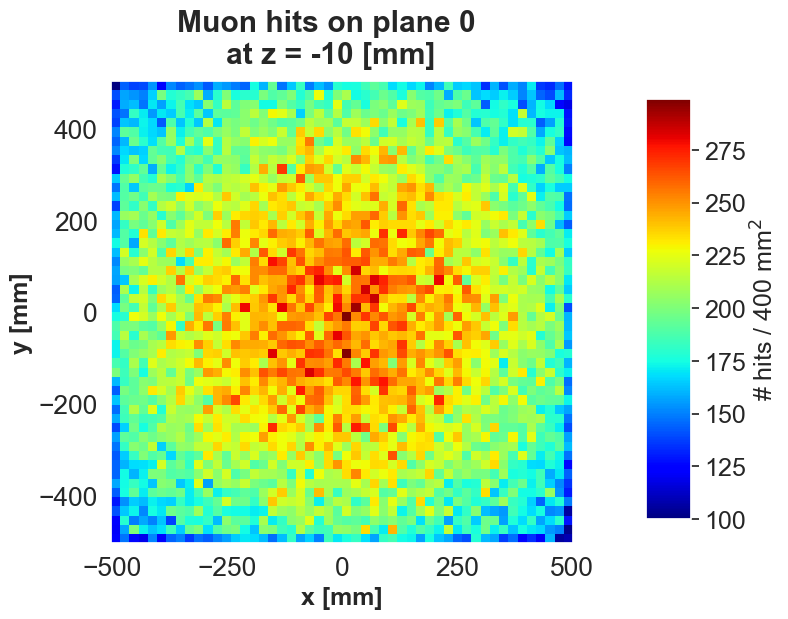

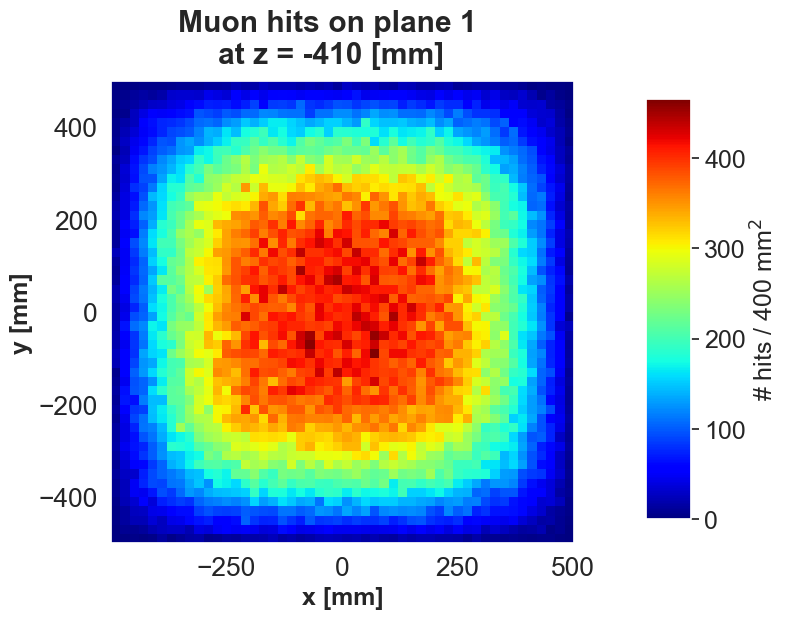

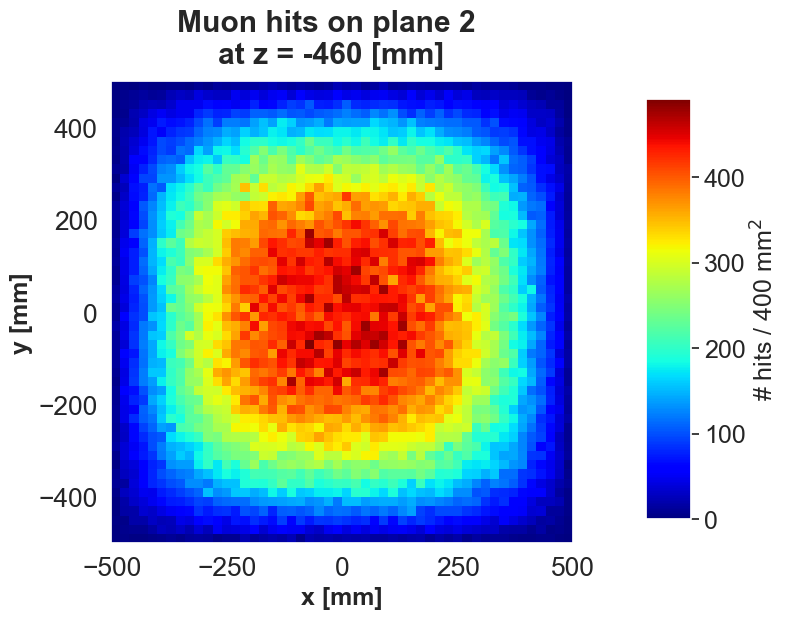

In [8]:
hits_in.plot(
    plane_label=0, # The tracker's label
    reco_hits=True, # Plot the reconstructed hits
    n_bins=50, # The number of bins of the histogram
    )

hits_in.plot(plane_label=1, reco_hits=True, n_bins=50)
hits_in.plot(plane_label=2, reco_hits=True, n_bins=50)


We repeat this process for the hits from the lower set of trackers:
    


In [9]:
hits_out = Hits(
    plane_labels=(3, 4, 5), # The labels of the lower panels 
    csv_filename=hits_csv_file, # The csv file to read the hits from
    spatial_res=(sigma_xy, sigma_xy, 0.), # Set the detectors spatial resolution in mm
    efficiency=.98, # Set the detectors efficiency,
    input_unit="mm", # The unit of the hits
    )

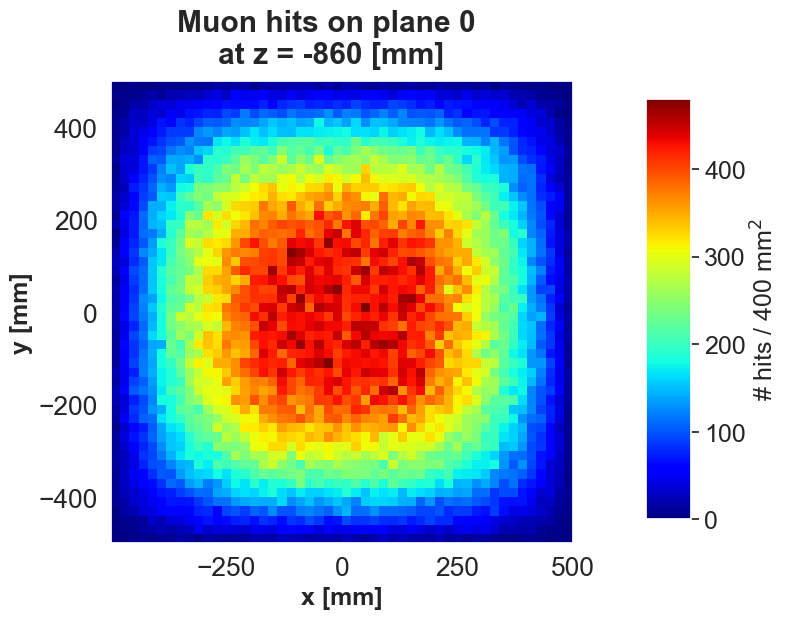

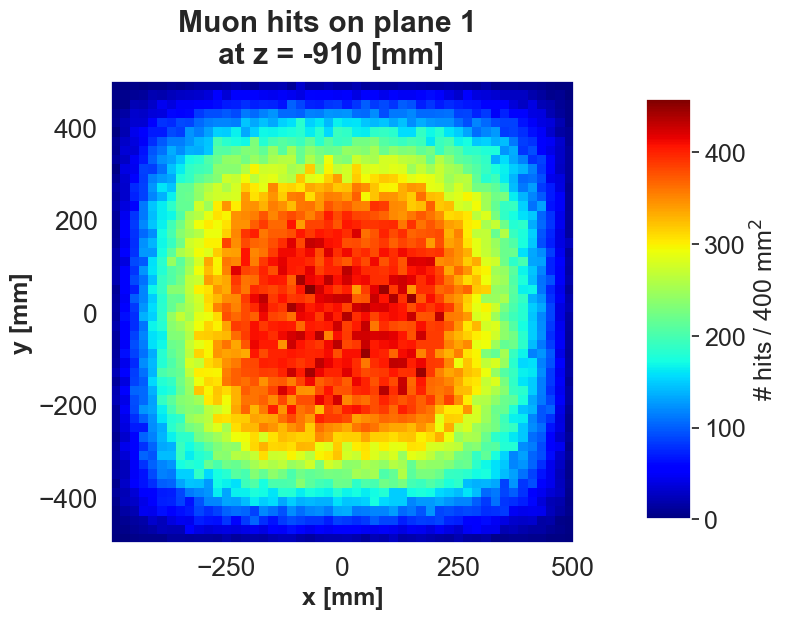

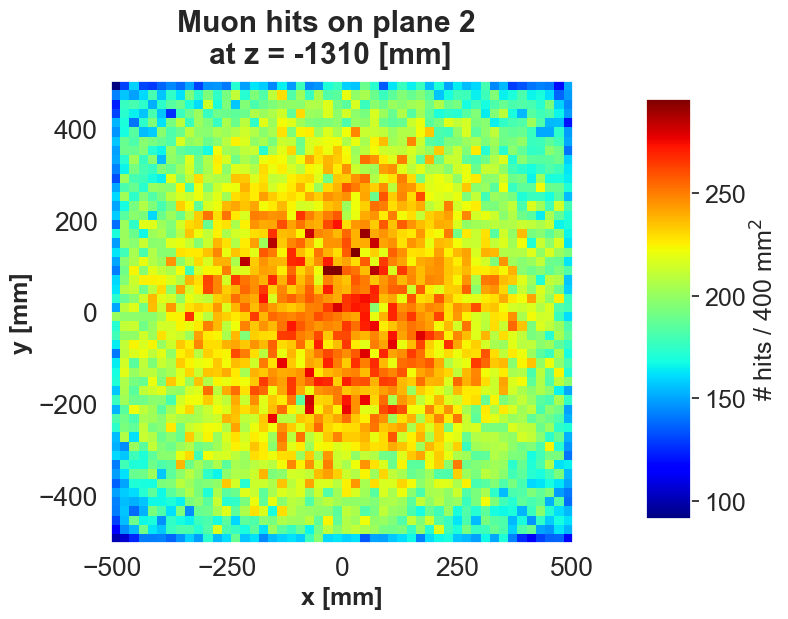

In [10]:
hits_out.plot(plane_label=0, reco_hits=True, n_bins=50)
hits_out.plot(plane_label=1, reco_hits=True, n_bins=50)
hits_out.plot(plane_label=2, reco_hits=True, n_bins=50)

The muon hits are then used as input of the tracking algorithm.

## III - Tracking

The 2 sets of muon hits are fitted independantly, in order to **measure** the **muon direction** before and after interacting with the object. The muon tracks features are automatically saved as `hdf5` file in the desired directory `output_dir`.

In [11]:
output_dir = "../output_test/small_statue_scattering/"

In [12]:
from muograph.tracking.tracking import Tracking 
tracks_in = Tracking(
    hits = hits_in, # An instance of the hits class 
    label = "above", # The position of the set of trackers w.r.t the object of interest
    output_dir=output_dir, # The directory where to save the tracking features
    )

../output_test/small_statue_scattering directory created
Class attributes saved at ../output_test/small_statue_scattering/tracks_above.hdf5


Once fitted, the tracks **zenith angle** $\theta$ is computed:

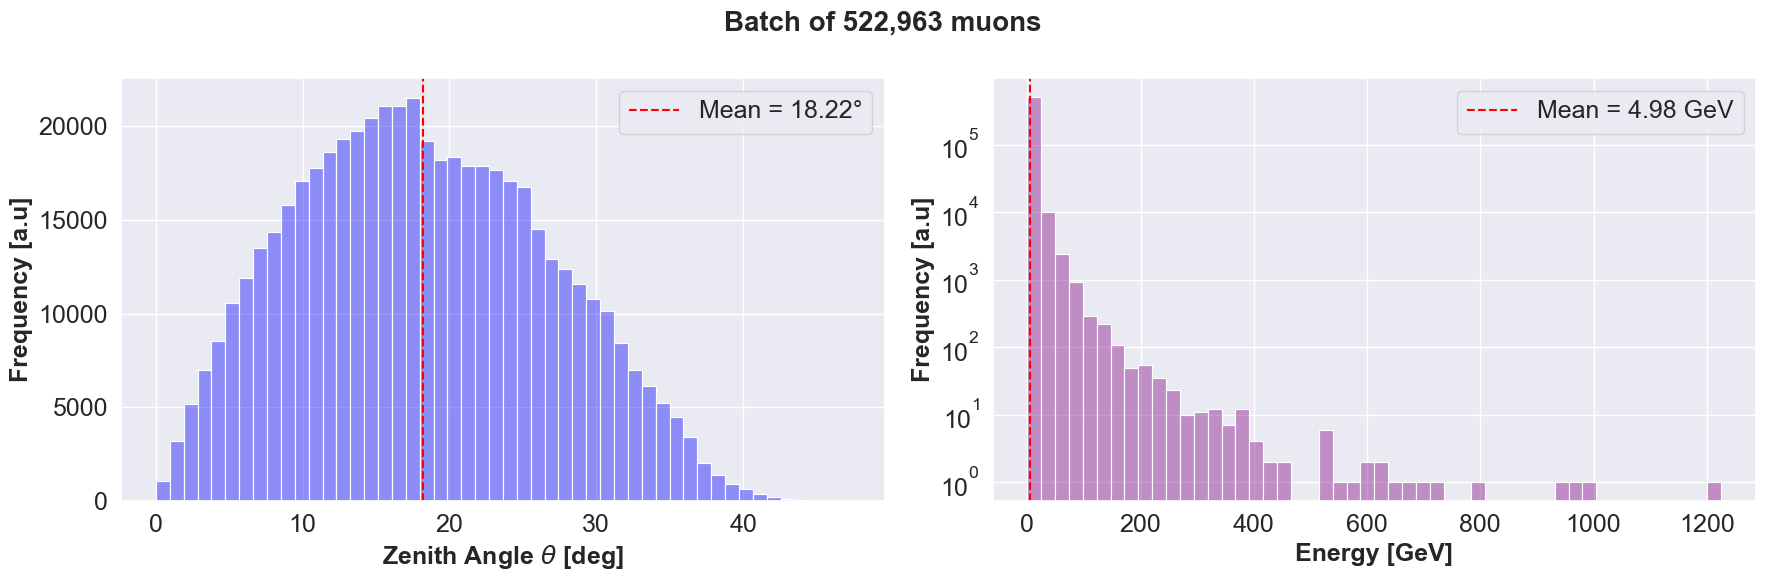

In [13]:
# Plot the incoming muon tracks features

tracks_in.plot_muon_features(figname=output_dir+"tracking_features")  # Figure will be saved in `tracks_in.output_dir` under the name 'tracks_theta_E_above.png'

Due to the 1mm **spatial resolution** of the trackers, the tracks computed from the reconstructed hits `reco_hits` are different from the one computed with the generated hits `gen_hits`. It introduces an error $\delta \theta$ on the reconstructed zenith angle:

$$
\delta \theta = \theta_{\mathrm{true}} - \theta_{\mathrm{rec}}
$$

Similarly to the spatial resolution, the **angular resolution** $\sigma_{\theta}$ is defined as the standard deviation of the angular error distribution $\delta \theta$:

$$
\sigma_{\theta} = \sigma \left( \delta \theta \right)
$$

The upper set of trackers has an angular resolution $\sigma_{\theta} = 0.15^{\circ}$.

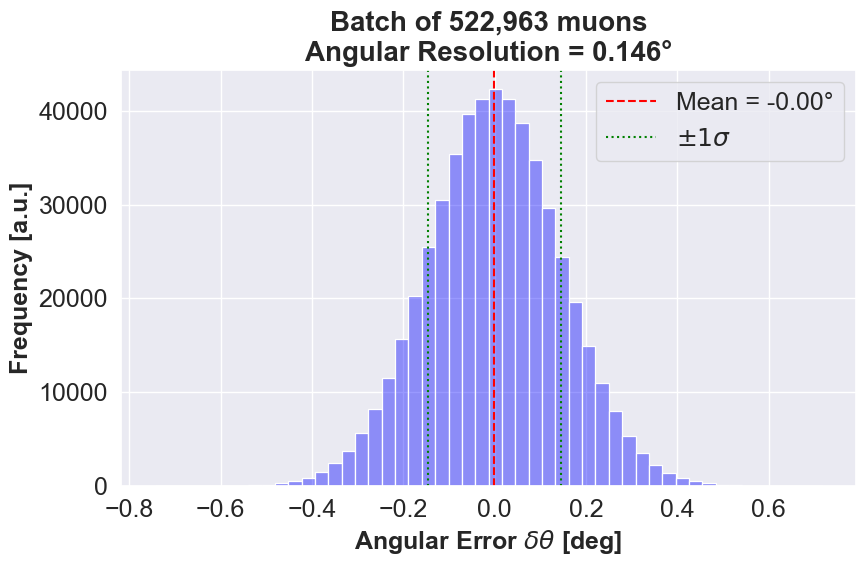

In [14]:
# Plot the incoming muon tracks angular error
tracks_in.plot_angular_error() 

We repeat the same proceedure for the set of trackers below the object: 

In [15]:
tracks_out = Tracking(
    hits = hits_out, 
    label = "below", 
    output_dir=output_dir
)
tracks_out

../output_test/small_statue_scattering directory created
Class attributes saved at ../output_test/small_statue_scattering/tracks_below.hdf5


Collection of tracks from 522,963 muons 
 with angular resolution = 0.15 deg

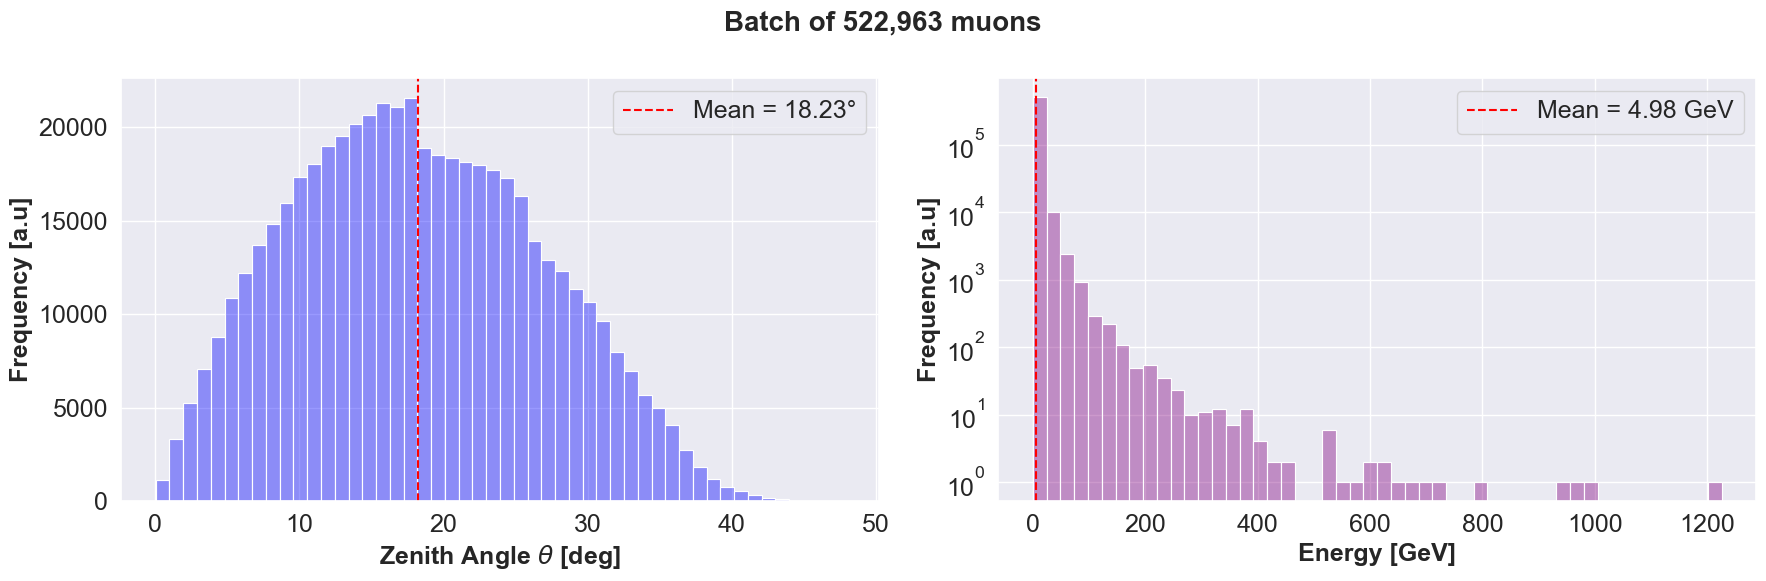

In [16]:
# Plot the incoming muon tracks features
tracks_out.plot_muon_features()

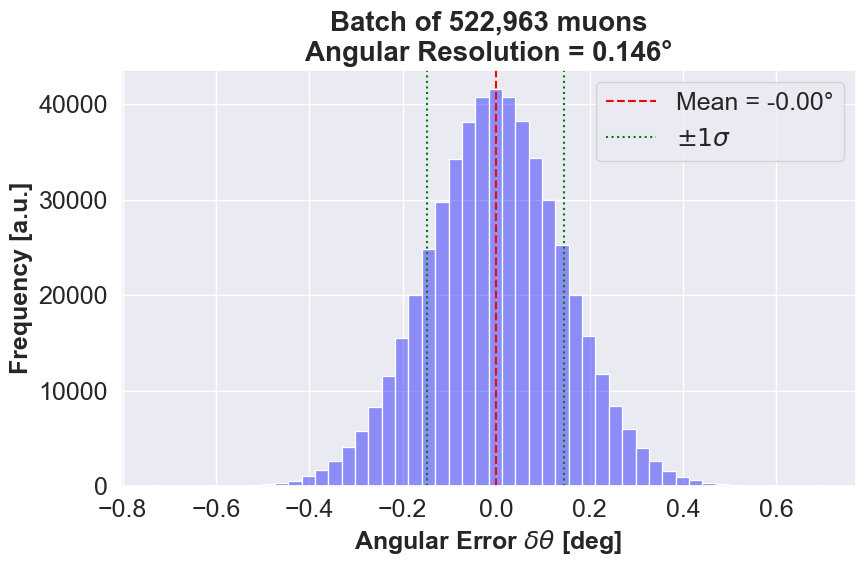

In [17]:
# Plot the incoming muon tracks angular error
tracks_out.plot_angular_error()

Without any surprises, the lower set of trackers has the same angular resolution as the upper one.

The 2 sets of tracks are then combined in a `TrackingMST` instance, by loading the the incoming and outgoing `Tracking` instances.

The `TrackingMST` class computes scattering angles and discards event based on the trackers efficiency. Only muons triggering every detector panels are kept. Given a indivdual tracker efficiency of $98\%$, the probability for a muon to trigger all 6 trackers $p_{trigg}$ is:

$$
p_{trigg} = 0.98 ^ 6 = 88.5 \%
$$

In [18]:
from muograph.tracking.tracking import TrackingMST
mst = TrackingMST(trackings= (tracks_in, tracks_out))
mst

Collection of tracks from 463,420 muons 
 with average angular resolution = 0.15 deg
 with tracking efficiency = 88.61 %

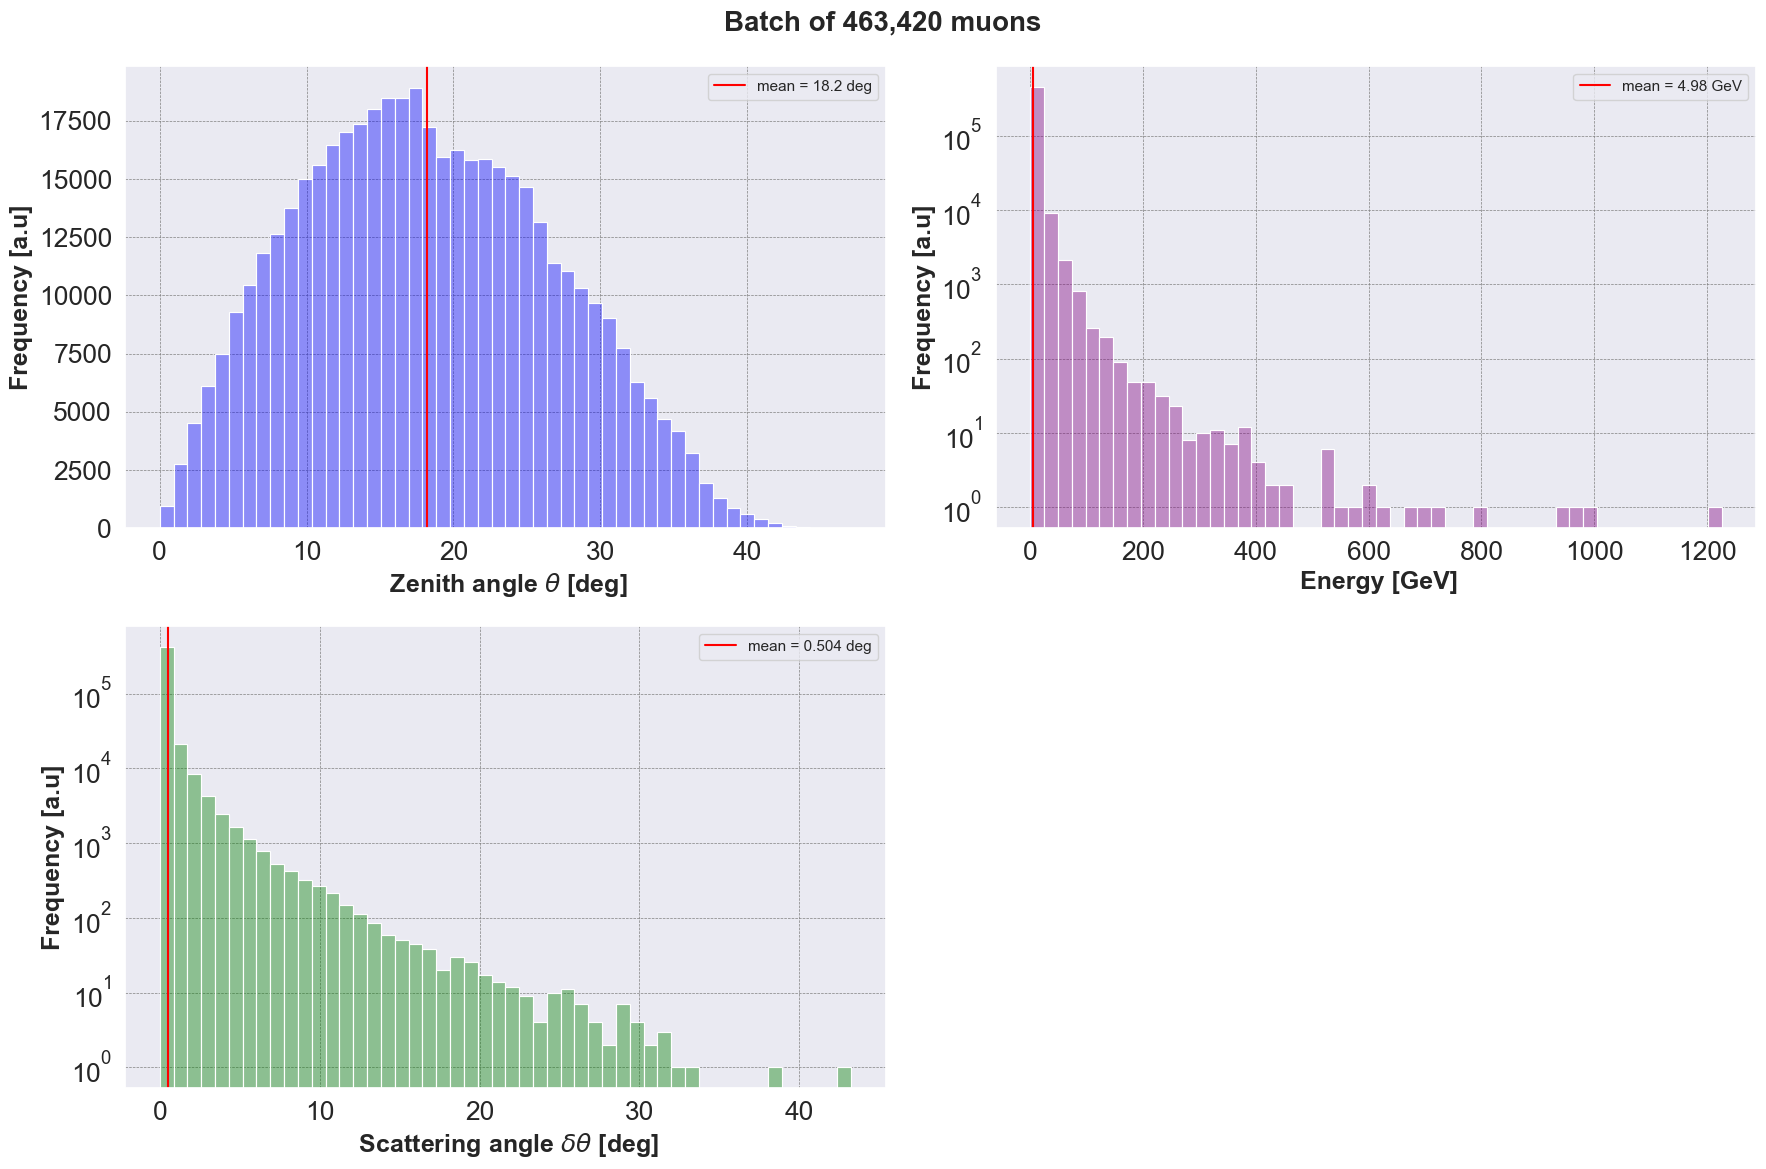

In [19]:
mst.plot_muon_features()

## **IV - Reconstruction**

Before running the reconstruction algorithms, we will **define** the **region of interest** to be imaged. 

In [20]:
from muograph.volume.volume import Volume
voi = Volume(
    position = (0, 0, -660), # The position of the center of the volume in x, y, z
    dimension = (360, 800, 400), # The span of of the volume in x, y, z
    voxel_width = (10, 10, 10) # The voxel size
    )

In order to get a **better signal to noise ratio**, we will **remove events** having **low scattering angle**. Most of these delfections do not originate from a muon traversing the object, but are an artifact of the detector's angular resolution.

We remove every muon with scattering angle $d\theta$ below $d\theta_{cut}$. The value of $d\theta_{cut}$ is chosen as 5 times the detector's angular resolution :

$$
d\theta_{cut} = 5 \sigma_{\theta}
$$

In [21]:
# Define scattering angle cut value
n_sigma = 5
dtheta_cut = mst.angular_res_in * n_sigma

# Filter events
mst._filter_muons(mst.dtheta > dtheta_cut)

We can now run the **POCA reconstruction algorithm** and compute the 3D **scattering density predictions** as the **number of poca point per voxel**:

In [22]:
from muograph.reconstruction.poca import POCA
poca = POCA(tracking = mst, voi=voi)
poca

Collection of 46461 POCA locations.

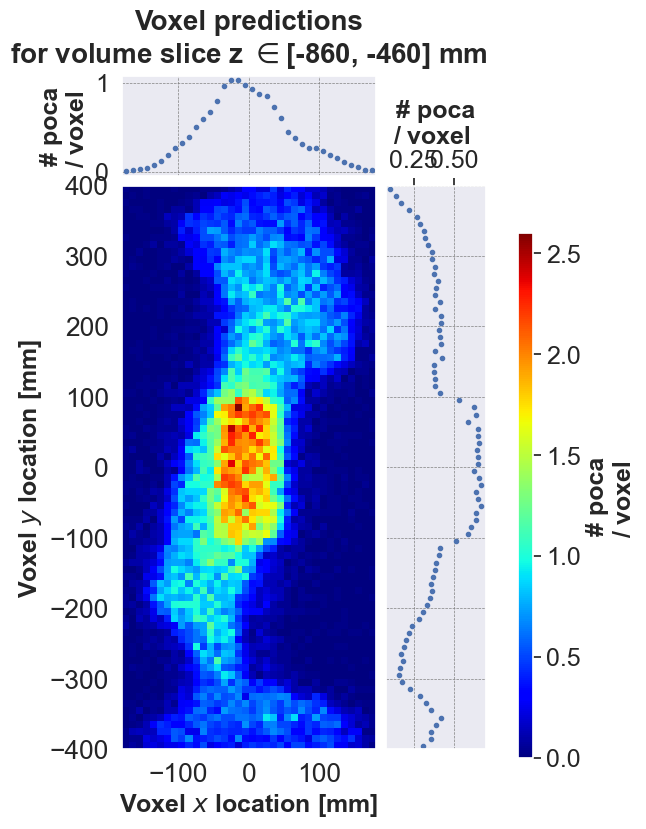

In [180]:
# Choose a projection
output_dir = "/home/geant/Downloads/"
dim = 2 # project along the 2nd dimension (Z) ==> XY projection

# Plot the predictions
poca.plot_pred_slice(
    voi = voi,
    xyz_voxel_preds = poca.n_poca_per_vox, # The predictions to plot
    dim = dim, # Projection along the z dimension (2 = z, 1 = y, 0 = x)
    voi_slice = (0, poca.voi.n_vox_xyz[dim] - 1), # The slices of voxels to consider
    pred_label = "# poca\n/ voxel", # The label of the prediction
    figname = output_dir + "n_poca",
    pred_unit = ""
)

While the figure above shows the number of poca points averaged over the whole volume of interest along the $z$ direction, one can plot the number of poca points per voxel for various slices of the volume of interest:

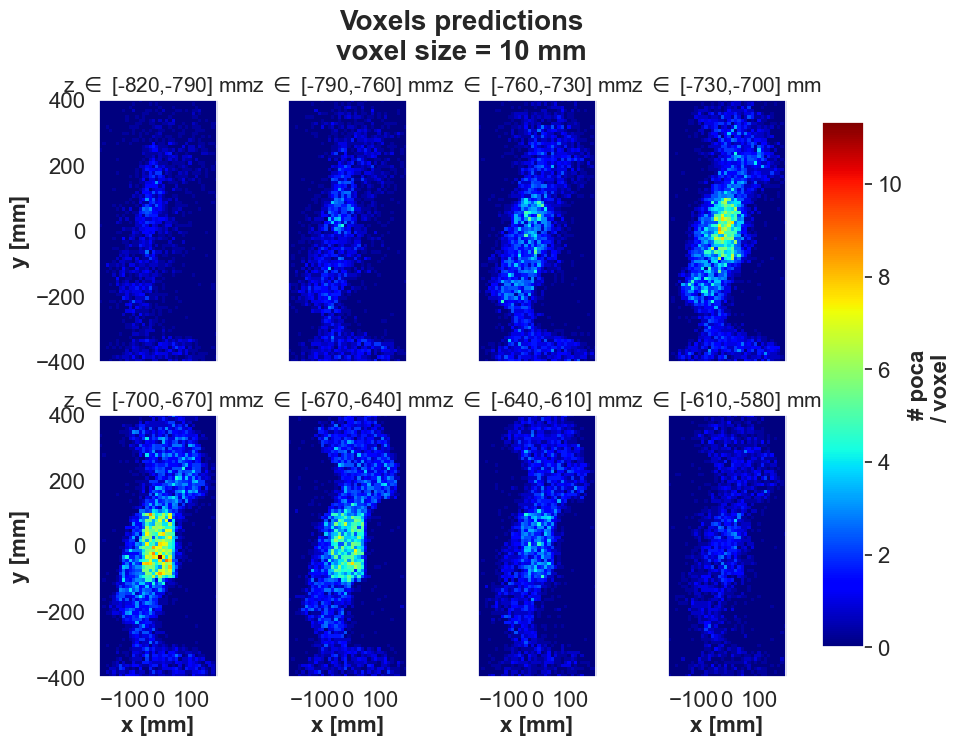

In [38]:
poca.plot_pred_by_slice(
    voi = poca.voi,
    xyz_voxel_preds=poca.n_poca_per_vox,# The predictions to plot
    dim = 2, # Projection along the z dimension (2 = z, 1 = y, 0 = x)
    figname= output_dir + "n_poca",
    voi_slice=(4, 28), # The range of voxels to consider along the chosen dimension 
    nslice_per_plot=3, # The number of voxels slices per plot
    ncols = 4, # The number of columns of the plot
    pred_label = "# poca\n/ voxel", # The label of the prediction
    )

At that stage, the **predictions** are still **noisy**. To adress this issue, we apply a **gaussian smoothing kernel** directly on the **3D scattering density predictions** with a kernel size of 1.5 voxel:

In [26]:
from muograph.utils.tools import apply_gaussian_filter
kernel_size = 1.5
smooth_poca = apply_gaussian_filter(
    poca.n_poca_per_vox, 
    sigma = (kernel_size, kernel_size, kernel_size)
    )

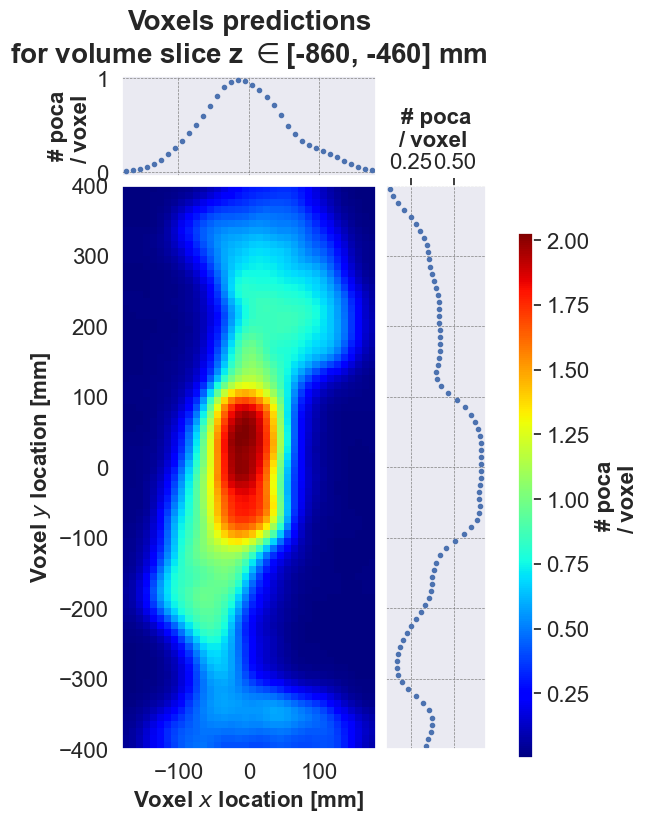

In [33]:
poca.plot_pred_slice(
    voi = voi,
    xyz_voxel_preds = smooth_poca,
    dim = 2,
    voi_slice = (0, poca.voi.n_vox_xyz[2] - 1),
    pred_label = "# poca\n/ voxel",
    figname = output_dir+ f"/smoothed_{kernel_size*10:.0f}_n_poca",
    pred_unit=""
)

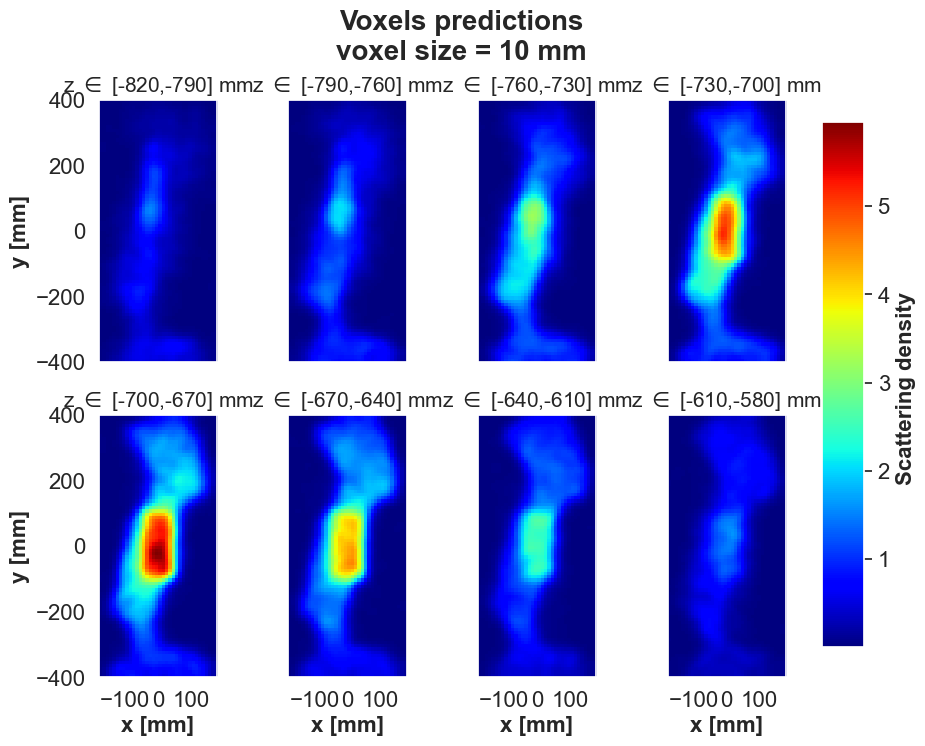

In [36]:
poca.plot_pred_by_slice(
    voi = poca.voi,
    xyz_voxel_preds = smooth_poca,
    figname = output_dir+ f"/smoothed_{kernel_size*10:.0f}_n_poca",
    voi_slice = (4, 28),
    nslice_per_plot = 3,
    ncols = 4,
    dim = 2,
    )